# 02 - Rollout with Baseline Policy

This notebook demonstrates a complete season simulation with the hand-coded baseline policy.

We'll visualize:
1. Environmental stress signals over time
2. Tree state evolution (biomass in each compartment)
3. Resource allocation decisions
4. Policy comparison across different climates

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from sim import ClimateConfig, SimConfig, run_season
from sim import policies, stress

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Environmental Stress Signals

First, let's visualize the sinusoidal stress signals for different climates.

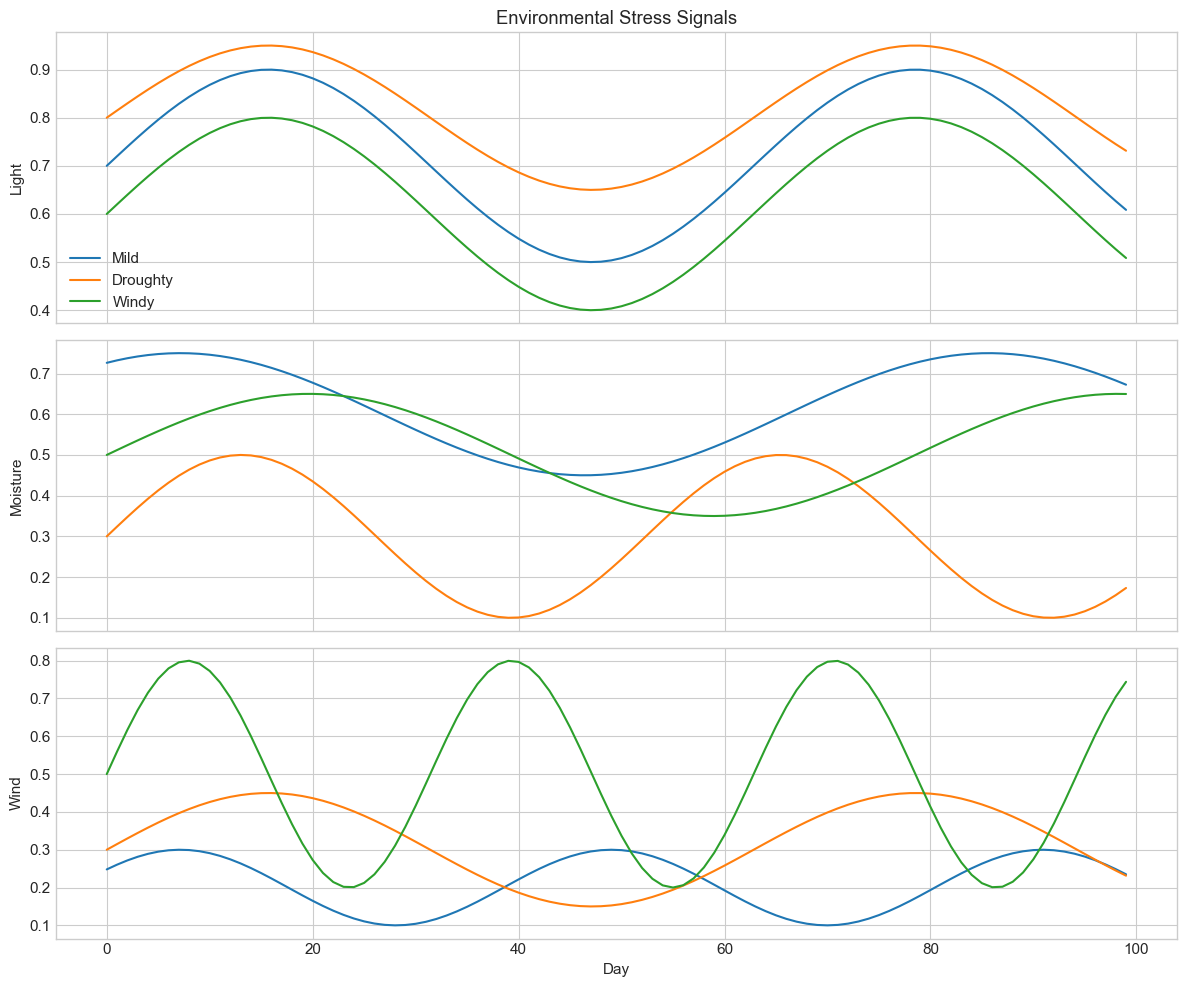

In [2]:
num_days = 100
days = np.arange(num_days)

climates = {
    'Mild': ClimateConfig.mild(),
    'Droughty': ClimateConfig.droughty(),
    'Windy': ClimateConfig.windy(),
}

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for name, climate in climates.items():
    light, moisture, wind = stress.compute_environment_batch(climate, num_days)
    
    axes[0].plot(days, light, label=name)
    axes[1].plot(days, moisture, label=name)
    axes[2].plot(days, wind, label=name)

axes[0].set_ylabel('Light')
axes[0].set_title('Environmental Stress Signals')
axes[0].legend()

axes[1].set_ylabel('Moisture')

axes[2].set_ylabel('Wind')
axes[2].set_xlabel('Day')

plt.tight_layout()
plt.show()

## 2. Single Season Rollout

Run a complete season with the baseline policy in a mild climate.

In [3]:
config = SimConfig(num_days=100)
climate = ClimateConfig.mild()

trajectory = run_season(
    config=config,
    climate=climate,
    policy=policies.baseline_policy,
)

print(f"Final seeds produced: {float(trajectory.seeds):.2f}")
print(f"Final biomass: {float(trajectory.states[-1].total_biomass()):.2f}")

Final seeds produced: 0.10
Final biomass: 2.62


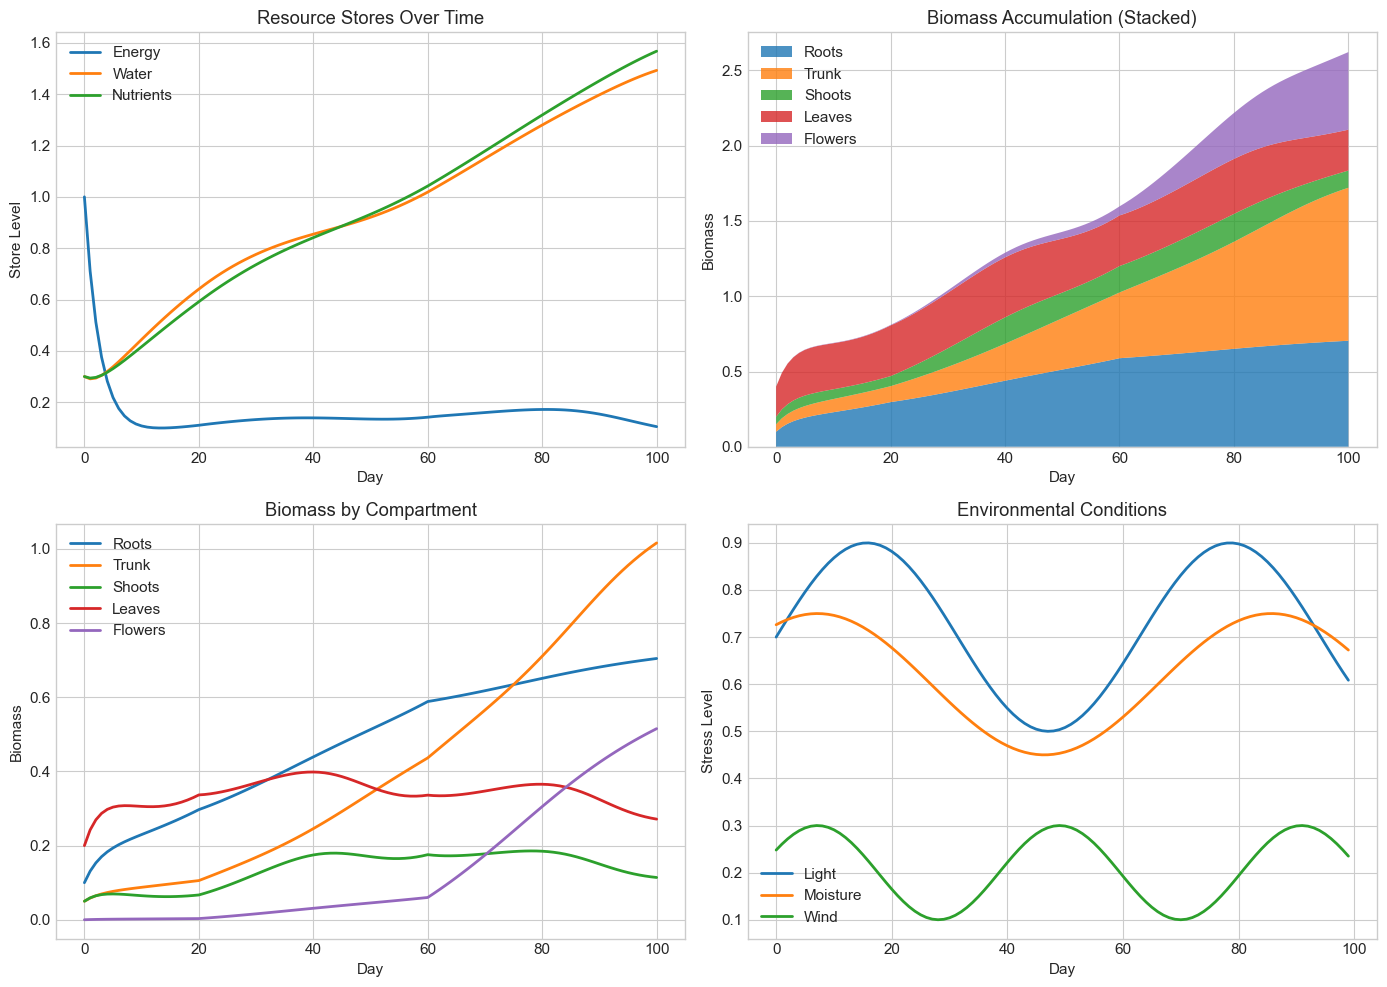

In [4]:
# Get state arrays for plotting
states = trajectory.get_state_arrays()
days = np.arange(len(trajectory.states))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Stores (Energy, Water, Nutrients)
ax = axes[0, 0]
ax.plot(days, states['energy'], label='Energy', linewidth=2)
ax.plot(days, states['water'], label='Water', linewidth=2)
ax.plot(days, states['nutrients'], label='Nutrients', linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Store Level')
ax.set_title('Resource Stores Over Time')
ax.legend()

# Plot 2: Biomass compartments
ax = axes[0, 1]
ax.stackplot(days,
    states['roots'],
    states['trunk'],
    states['shoots'],
    states['leaves'],
    states['flowers'],
    labels=['Roots', 'Trunk', 'Shoots', 'Leaves', 'Flowers'],
    alpha=0.8
)
ax.set_xlabel('Day')
ax.set_ylabel('Biomass')
ax.set_title('Biomass Accumulation (Stacked)')
ax.legend(loc='upper left')

# Plot 3: Individual biomass lines
ax = axes[1, 0]
ax.plot(days, states['roots'], label='Roots', linewidth=2)
ax.plot(days, states['trunk'], label='Trunk', linewidth=2)
ax.plot(days, states['shoots'], label='Shoots', linewidth=2)
ax.plot(days, states['leaves'], label='Leaves', linewidth=2)
ax.plot(days, states['flowers'], label='Flowers', linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Biomass')
ax.set_title('Biomass by Compartment')
ax.legend()

# Plot 4: Stress signals
ax = axes[1, 1]
stress_days = np.arange(len(trajectory.light_history))
ax.plot(stress_days, trajectory.light_history, label='Light', linewidth=2)
ax.plot(stress_days, trajectory.moisture_history, label='Moisture', linewidth=2)
ax.plot(stress_days, trajectory.wind_history, label='Wind', linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Stress Level')
ax.set_title('Environmental Conditions')
ax.legend()

plt.tight_layout()
plt.show()

## 3. Allocation Strategy Over Time

Visualize how the baseline policy allocates resources throughout the season.

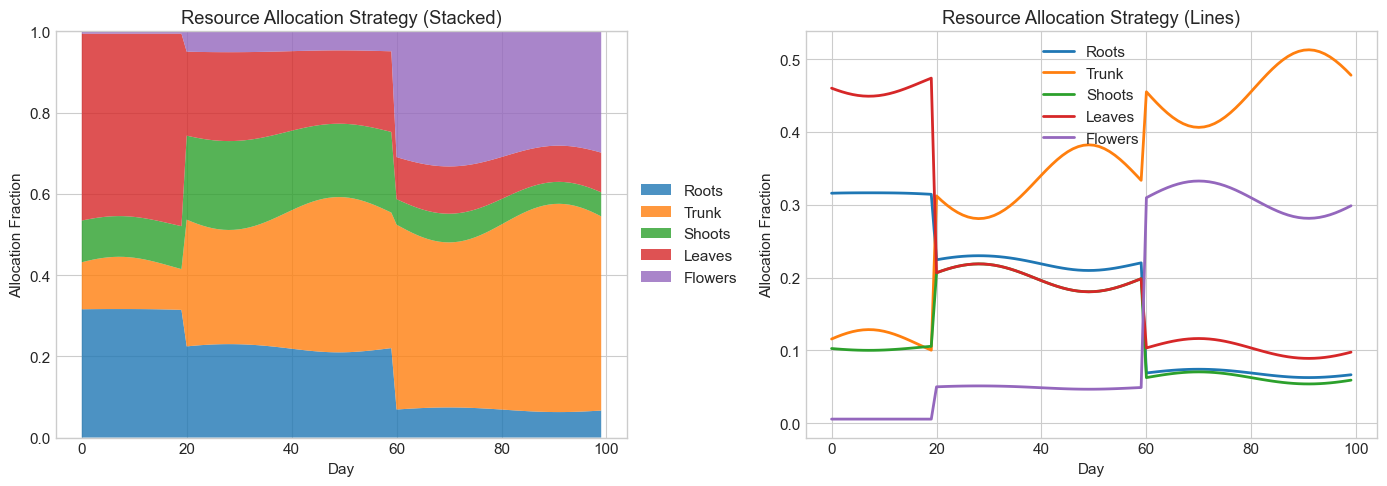

In [5]:
allocations = trajectory.get_allocation_arrays()
alloc_days = np.arange(len(trajectory.allocations))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stacked area plot
ax1.stackplot(alloc_days,
    allocations['roots'],
    allocations['trunk'],
    allocations['shoots'],
    allocations['leaves'],
    allocations['flowers'],
    labels=['Roots', 'Trunk', 'Shoots', 'Leaves', 'Flowers'],
    alpha=0.8
)
ax1.set_xlabel('Day')
ax1.set_ylabel('Allocation Fraction')
ax1.set_title('Resource Allocation Strategy (Stacked)')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_ylim(0, 1)

# Line plot
ax2.plot(alloc_days, allocations['roots'], label='Roots', linewidth=2)
ax2.plot(alloc_days, allocations['trunk'], label='Trunk', linewidth=2)
ax2.plot(alloc_days, allocations['shoots'], label='Shoots', linewidth=2)
ax2.plot(alloc_days, allocations['leaves'], label='Leaves', linewidth=2)
ax2.plot(alloc_days, allocations['flowers'], label='Flowers', linewidth=2)
ax2.set_xlabel('Day')
ax2.set_ylabel('Allocation Fraction')
ax2.set_title('Resource Allocation Strategy (Lines)')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Policy Comparison

Compare different policies in the same climate.

In [6]:
from sim.rollout import compare_policies

policy_dict = {
    'Baseline': policies.baseline_policy,
    'Growth-focused': policies.growth_focused_policy,
    'Defensive': policies.defensive_policy,
    'Reproduction': policies.reproduction_policy,
}

results = compare_policies(policy_dict, config, ClimateConfig.mild())

print("\nPolicy Comparison (Mild Climate):")
print("-" * 50)
for name, metrics in results.items():
    print(f"{name:20} Seeds: {metrics['mean_seeds']:8.2f}  Biomass: {metrics['mean_biomass']:8.2f}")


Policy Comparison (Mild Climate):
--------------------------------------------------
Baseline             Seeds:     0.10  Biomass:     2.62
Growth-focused       Seeds:     0.06  Biomass:     2.96
Defensive            Seeds:     0.01  Biomass:     1.23
Reproduction         Seeds:     0.02  Biomass:     0.53


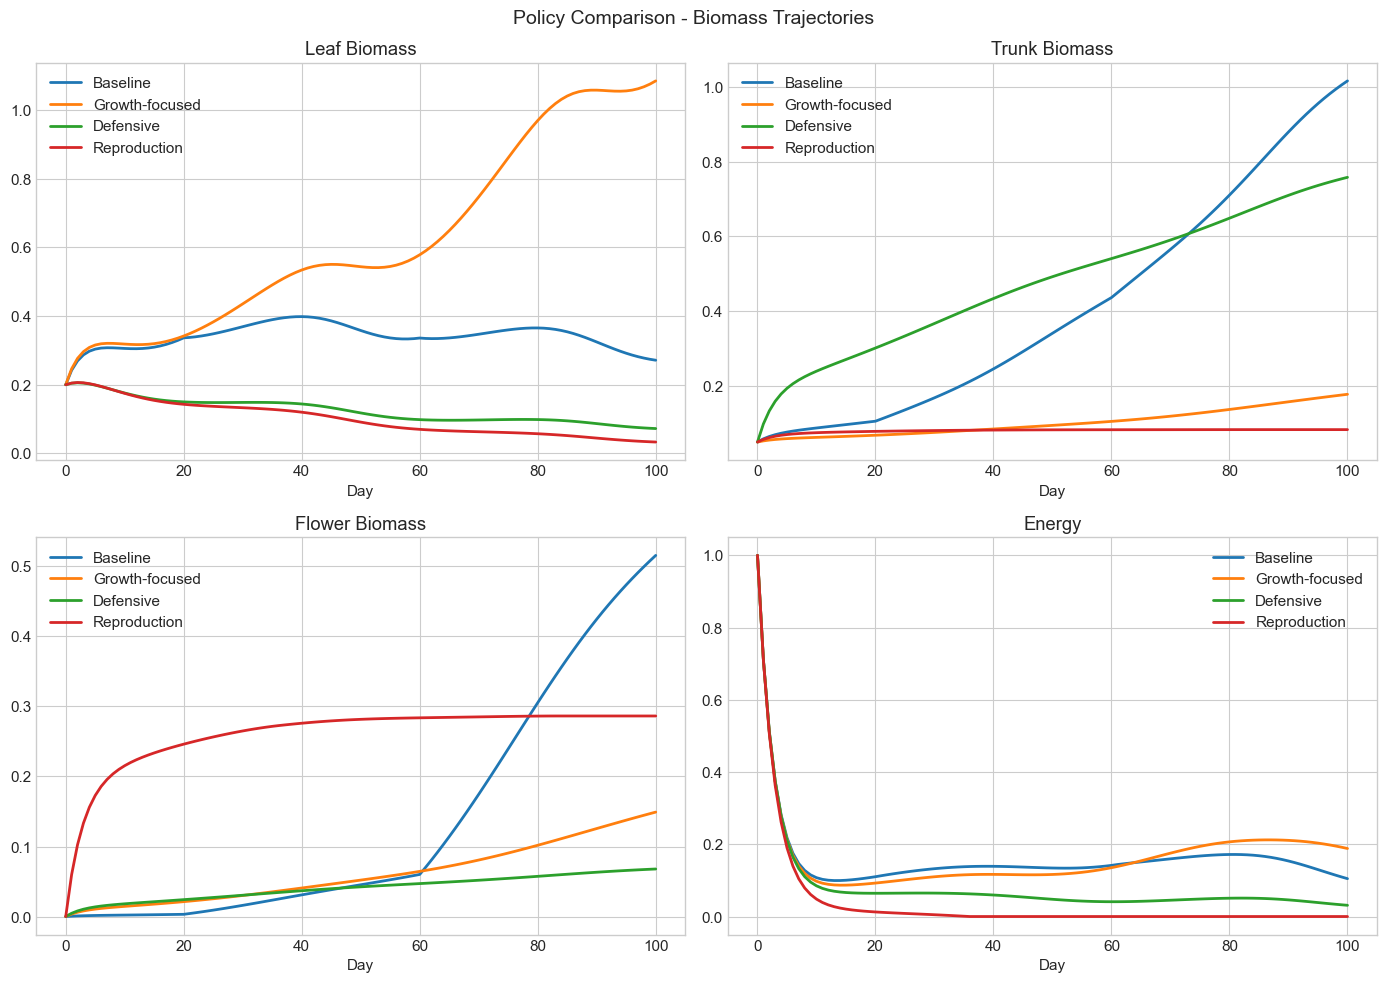

In [7]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for name, policy in policy_dict.items():
    traj = run_season(config, ClimateConfig.mild(), policy)
    states = traj.get_state_arrays()
    days = np.arange(len(traj.states))
    
    axes[0, 0].plot(days, states['leaves'], label=name, linewidth=2)
    axes[0, 1].plot(days, states['trunk'], label=name, linewidth=2)
    axes[1, 0].plot(days, states['flowers'], label=name, linewidth=2)
    axes[1, 1].plot(days, states['energy'], label=name, linewidth=2)

axes[0, 0].set_title('Leaf Biomass')
axes[0, 0].set_xlabel('Day')
axes[0, 0].legend()

axes[0, 1].set_title('Trunk Biomass')
axes[0, 1].set_xlabel('Day')
axes[0, 1].legend()

axes[1, 0].set_title('Flower Biomass')
axes[1, 0].set_xlabel('Day')
axes[1, 0].legend()

axes[1, 1].set_title('Energy')
axes[1, 1].set_xlabel('Day')
axes[1, 1].legend()

plt.suptitle('Policy Comparison - Biomass Trajectories', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Climate Comparison

Run the baseline policy across different climates.

In [8]:
climate_results = {}
for name, climate in climates.items():
    traj = run_season(config, climate, policies.baseline_policy)
    climate_results[name] = {
        'trajectory': traj,
        'seeds': float(traj.seeds),
        'final_biomass': float(traj.states[-1].total_biomass()),
    }

print("\nBaseline Policy Across Climates:")
print("-" * 50)
for name, data in climate_results.items():
    print(f"{name:15} Seeds: {data['seeds']:8.2f}  Final Biomass: {data['final_biomass']:8.2f}")


Baseline Policy Across Climates:
--------------------------------------------------
Mild            Seeds:     0.10  Final Biomass:     2.62
Droughty        Seeds:     0.00  Final Biomass:     0.64
Windy           Seeds:     0.00  Final Biomass:     0.37


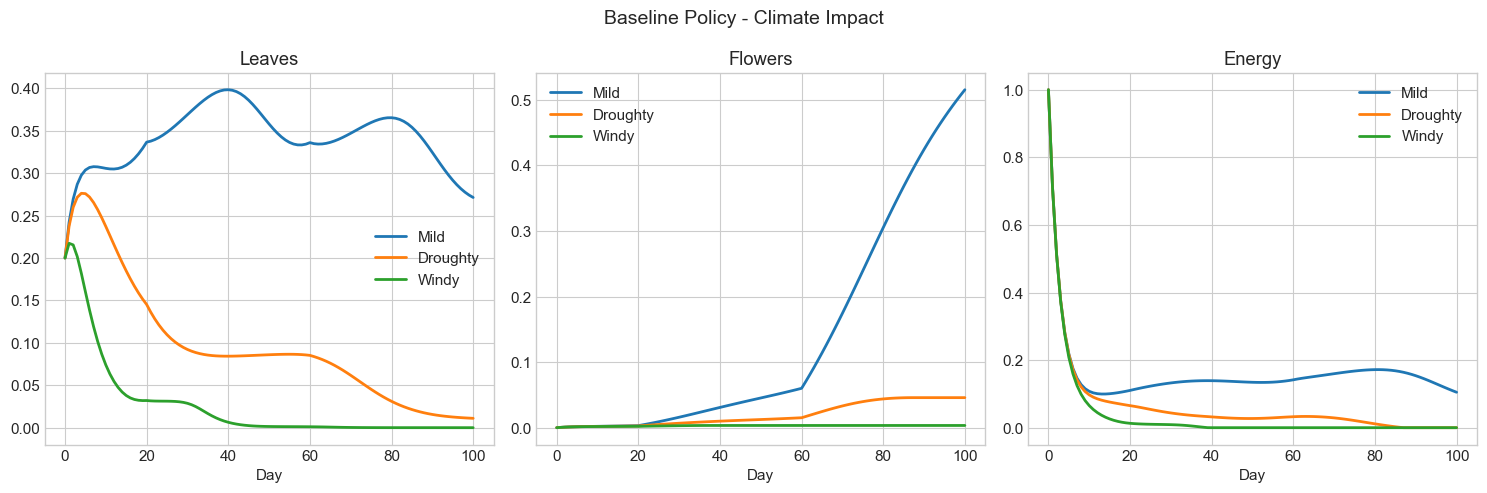

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for name, data in climate_results.items():
    states = data['trajectory'].get_state_arrays()
    days = np.arange(len(data['trajectory'].states))
    
    axes[0].plot(days, states['leaves'], label=name, linewidth=2)
    axes[1].plot(days, states['flowers'], label=name, linewidth=2)
    axes[2].plot(days, states['energy'], label=name, linewidth=2)

axes[0].set_title('Leaves')
axes[0].set_xlabel('Day')
axes[0].legend()

axes[1].set_title('Flowers')
axes[1].set_xlabel('Day')
axes[1].legend()

axes[2].set_title('Energy')
axes[2].set_xlabel('Day')
axes[2].legend()

plt.suptitle('Baseline Policy - Climate Impact', fontsize=14)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Environmental stress signals**: Sinusoidal patterns for light, moisture, and wind
2. **Season rollout**: Complete simulation with state tracking
3. **Allocation visualization**: How the baseline policy shifts strategy over time
4. **Policy comparison**: Different strategies produce different outcomes
5. **Climate impact**: Environmental conditions affect growth and reproduction

### Key Observations

- The baseline policy follows PvZ economics: roots/leaves early, trunk mid, flowers late
- Harsh climates (wind, drought) reduce seed production
- Different policies excel in different metrics (biomass vs seeds)
- The simulation is differentiable and ready for gradient-based optimization